# ConvLSTM Expl: Convolutional LSTM Network Tutorial

### This notebook demonstrates the use of a convolutional LSTM network.

This network is used to predict the next frame of an artificially
generated movie which contains moving squares.

WARNING: please run it with KAGGLE. For unknown reasons works better!
Code based on: https://keras.io/examples/vision/conv_lstm/ 

## Imports

In [1]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

Using TensorFlow backend.


## Model

We create a layer which take as input movies of shape `(n_frames, width, height, channels)` and returns a movie of identical shape.

In [2]:
seq = Sequential()

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')

In [3]:
seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 40, 40, 40)  59200     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
__________

## Artificial data generation

Generate movies with 3 to 7 moving squares inside.

The squares are of shape 1x1 or 2x2 pixels, which move linearly over time.

For convenience we first create movies with bigger width and height (80x80) and at the end we select a 40x40 window.

In [4]:
def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

In [5]:
noisy_movies, shifted_movies = generate_movies(n_samples=1200)

`(batch_size, time_steps, height, width, filters (layers)`

In [6]:
noisy_movies.shape, shifted_movies.shape

((1200, 15, 40, 40, 1), (1200, 15, 40, 40, 1))

## Train the network

In [14]:
%%time
seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10,
        epochs=5, validation_split=0.05)

Train on 950 samples, validate on 50 samples
Epoch 1/5
950/950 [==============================] - 128s 135ms/step - loss: 4.0133e-04 - val_loss: 1.3493e-04
Epoch 2/5
950/950 [==============================] - 126s 132ms/step - loss: 2.0074e-04 - val_loss: 1.4782e-04
Epoch 3/5
950/950 [==============================] - 124s 130ms/step - loss: 1.5527e-04 - val_loss: 1.0804e-04
Epoch 4/5
950/950 [==============================] - 126s 133ms/step - loss: 1.3299e-04 - val_loss: 1.2817e-04
Epoch 5/5
950/950 [==============================] - 127s 133ms/step - loss: 1.1237e-04 - val_loss: 8.3853e-05
CPU times: user 12min 49s, sys: 25.4 s, total: 13min 15s
Wall time: 10min 30s


## Testing the network on one movie

Feed it with the first 7 positions and then predict the new positions

In [8]:
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]

Let's check the dimensions of the following array to better understand what's going on here.

`track` has the shape of 7 frames 40\*40 with one channel. `np.newaxis` adds additional axis so the array can be accepted by the `seq` model.

In [9]:
track.shape, track[np.newaxis, ::, ::, ::, ::].shape

((7, 40, 40, 1), (1, 7, 40, 40, 1))

In [10]:
for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::]) # (1, 7, 40, 40, 1)
    new = new_pos[::, -1, ::, ::, ::] # (1, 40, 40, 1)
    track = np.concatenate((track, new), axis=0) # adds +1 to the first dimension in each loop cycle

## Compare the predictions to the ground truth

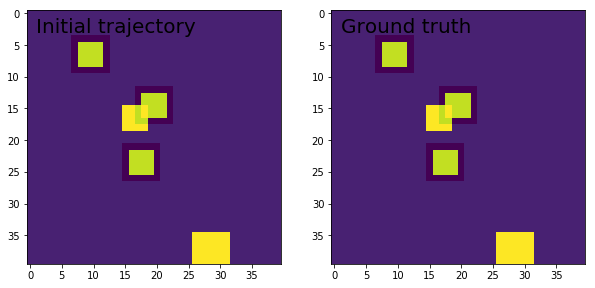

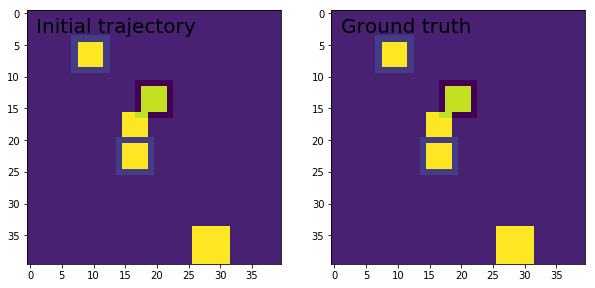

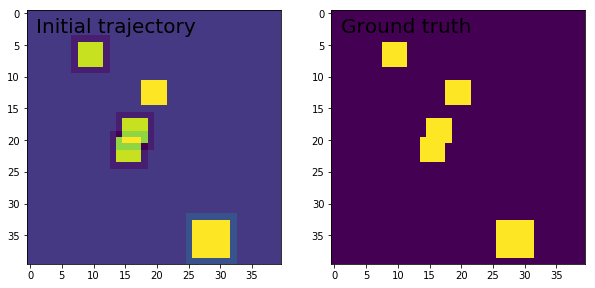

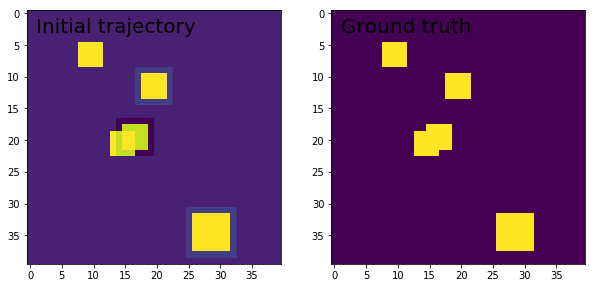

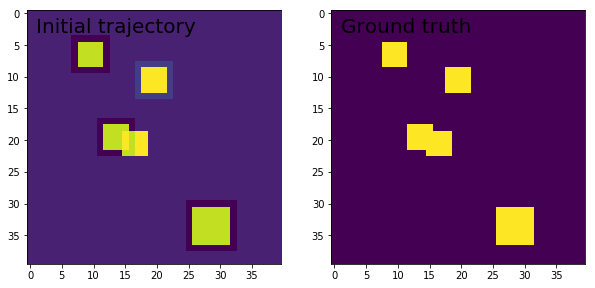

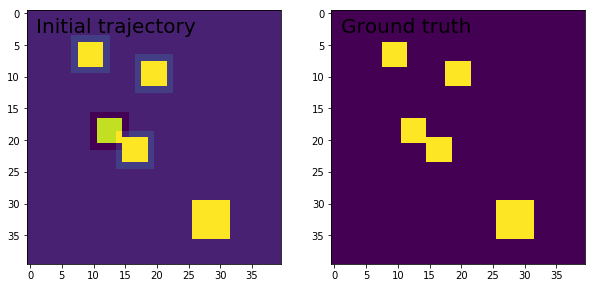

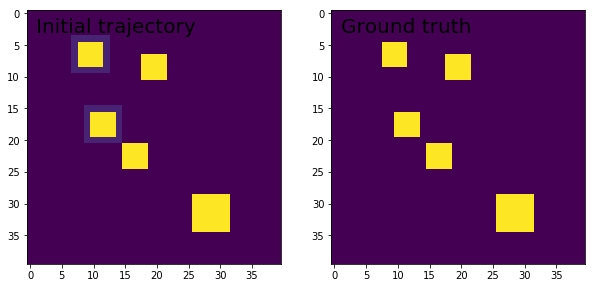

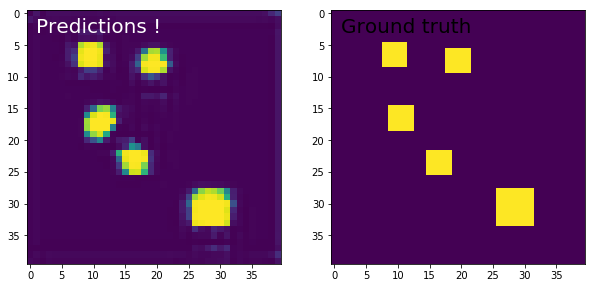

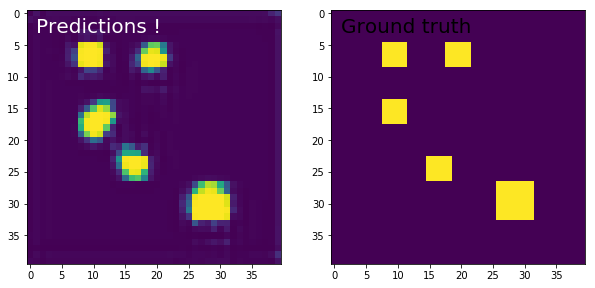

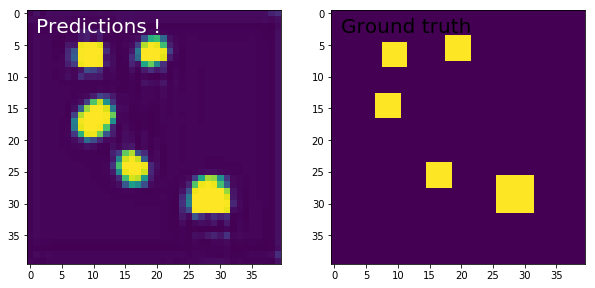

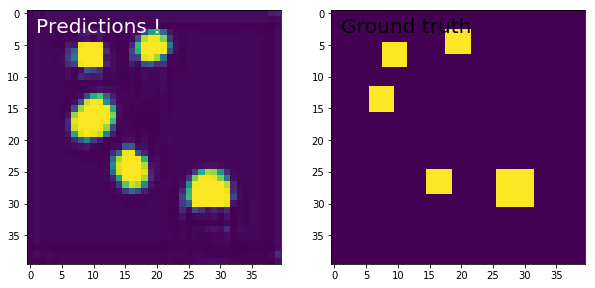

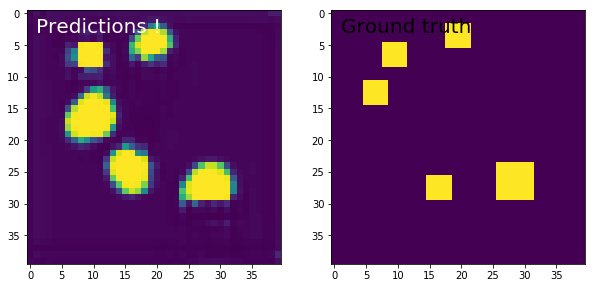

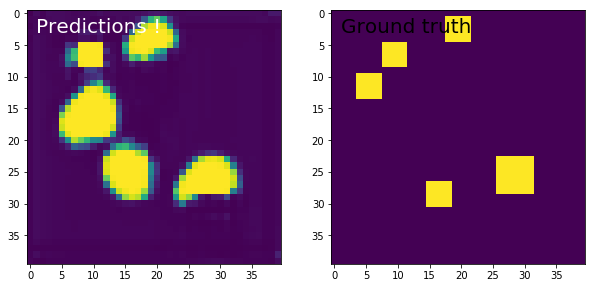

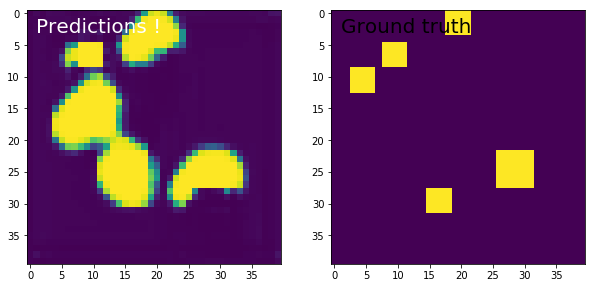

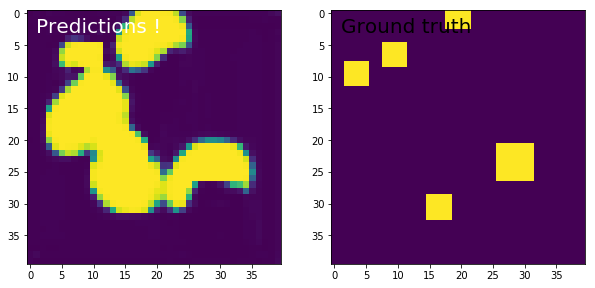

In [11]:
track2 = noisy_movies[which][::, ::, ::, ::]

for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))